In [1]:
!pip install transformers torch

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig, get_linear_schedule_with_warmup
from torch.optim import AdamW

from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Download datasets from Kaggle

In [3]:
import kagglehub

path = kagglehub.dataset_download("infamouscoder/depression-reddit-cleaned")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'depression-reddit-cleaned' dataset.
Path to dataset files: /kaggle/input/depression-reddit-cleaned


In [4]:
# Read data
df = pd.read_csv(path + "/depression_dataset_reddit_cleaned.csv")
df['clean_text'] = df['clean_text'].astype(str)

df.size

15462

In [5]:
# Check for duplicates
df = df.drop_duplicates(subset='clean_text', keep='first')
df = df.reset_index(drop=True)

df.size

15300

In [6]:
# Maximum length of text
max_length = df['clean_text'].apply(len).max()

print(max_length)

19822


In [7]:
# Minimum length of text
min_length = df['clean_text'].apply(len).min()

print(min_length)

3


In [8]:
# Create a column for text length
df['text_length'] = df['clean_text'].apply(len)

# Get top 10 longest texts
top5_longest = df.nlargest(10, 'text_length')

# Display index, length, class, and a preview
for idx, row in top5_longest.iterrows():
    print(f"Index: {idx}")
    print(f"Length: {row['text_length']}")
    print(f"Class: {row['is_depression']}")
    print(f"Text preview: {row['clean_text'][:500]}...\n")  # Show first 500 chars
    print("-" * 80)

Index: 2068
Length: 19822
Class: 1
Text preview: it doesn t matter anymore i m going to copy and paste my note it really doesn t matter i know i m spilling my gut out oh who care now i m lonely i m a solider to my self pride status something i fail to achieve my whole life achieving to be a boy the one my parent are proud of the only reason i m not forgotten is because i m away from home do you think they remember me i m so fine with being lonesome i could live i no longer cry i no longer care i m not deep i m not feminine i no longer attract ...

--------------------------------------------------------------------------------
Index: 1898
Length: 9983
Class: 1
Text preview: we ve been seeing a worrying increase in pro suicide content showing up here and and also going unreported this undermines our purpose here so we wanted to highlight and clarify our guideline about both direct and indirect incitement of suicide we ve created a wiki that cover these issue we hope this will be helpful

In [9]:
# Find the shortest text based on length
shortest_text_row = df.loc[df['text_length'].idxmin()]

# Get top 10 shortest texts
top5_shortest = df.nsmallest(10, 'text_length')

# Display index, length, class, and a preview
for idx, row in top5_shortest.iterrows():
    print(f"Index: {idx}")
    print(f"Length: {row['text_length']}")
    print(f"Class: {row['is_depression']}")
    print(f"Text preview: {row['clean_text'][:200]}...")  # Show first 200 characters
    print("-" * 80)

Index: 2187
Length: 3
Class: 1
Text preview: plz...
--------------------------------------------------------------------------------
Index: 4305
Length: 7
Class: 0
Text preview: at work...
--------------------------------------------------------------------------------
Index: 4340
Length: 7
Class: 0
Text preview: evicted...
--------------------------------------------------------------------------------
Index: 5098
Length: 7
Class: 0
Text preview: is cold...
--------------------------------------------------------------------------------
Index: 6163
Length: 7
Class: 0
Text preview: so cold...
--------------------------------------------------------------------------------
Index: 7016
Length: 7
Class: 0
Text preview: bad day...
--------------------------------------------------------------------------------
Index: 3896
Length: 8
Class: 0
Text preview: agh snow...
--------------------------------------------------------------------------------
Index: 3969
Length: 8
Class: 0
Text preview:

In [10]:
# Statistics of text_length for depression and non-depression texts
df.groupby('is_depression')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
is_depression,,,,,,,,
0,3889.0,69.779635,34.554819,7.0,41.0,66.0,98.0,144.0
1,3761.0,657.023132,882.891655,3.0,167.0,374.0,828.0,19822.0


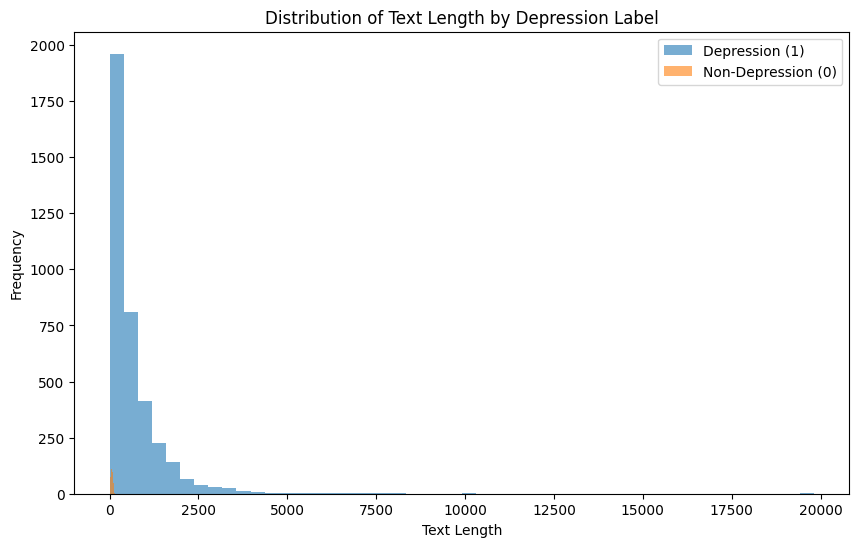

In [11]:
# plot the Distribution of Text Length by Depression Label
plt.figure(figsize=(10,6))
plt.hist(df[df['is_depression']==1]['text_length'], bins=50, alpha=0.6, label='Depression (1)')
plt.hist(df[df['is_depression']==0]['text_length'], bins=50, alpha=0.6, label='Non-Depression (0)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length by Depression Label')
plt.legend()
plt.show()

# Truncate the text to a fixed maximum length

In [12]:
# truncate the text to 500 characters
df['truncated_text'] = df['clean_text'].str.slice(0, 500)
df['truncated_text_length'] = df['truncated_text'].str.len()
df.head()

,clean_text,is_depression,text_length,truncated_text,truncated_text_length
0,we understand that most people who reply immed...,1,4535,we understand that most people who reply immed...,500
1,welcome to r depression s check in post a plac...,1,2394,welcome to r depression s check in post a plac...,500
2,anyone else instead of sleeping more when depr...,1,236,anyone else instead of sleeping more when depr...,236
3,i ve kind of stuffed around a lot in my life d...,1,510,i ve kind of stuffed around a lot in my life d...,500
4,sleep is my greatest and most comforting escap...,1,281,sleep is my greatest and most comforting escap...,281


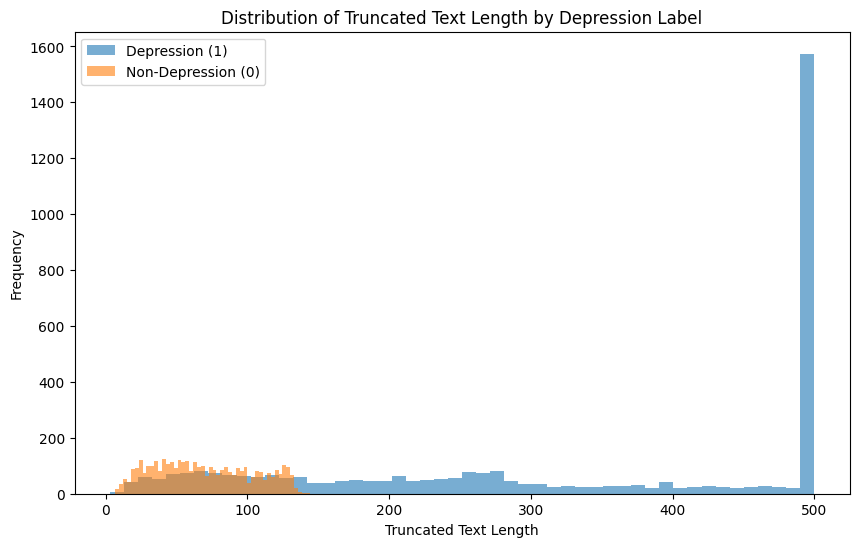

In [13]:
# plot the Distribution of Truncated Text Length by Depression Label
plt.figure(figsize=(10,6))
plt.hist(df[df['is_depression']==1]['truncated_text_length'], bins=50, alpha=0.6, label='Depression (1)')
plt.hist(df[df['is_depression']==0]['truncated_text_length'], bins=50, alpha=0.6, label='Non-Depression (0)')
plt.xlabel('Truncated Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Truncated Text Length by Depression Label')
plt.legend()
plt.show()

# Vectorized XLNet Tokenization with Train–Validation–Test Split and DataLoader Preparation

In [15]:
# Vectorized tokenization and conversion to input IDs + attention masks
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
MAX_LEN = 256

encoding = tokenizer(
    df['truncated_text'].tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract input IDs and attention masks
input_ids = encoding['input_ids']        # tensor of shape (num_samples, max_length)
attention_masks = encoding['attention_mask']  # tensor of same shape

labels = torch.tensor(df['is_depression'].values)

# First split into train and temp (val+test)
train_inputs, temp_inputs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    input_ids, labels, attention_masks, test_size=0.2, random_state=42
)

# Then split temp into validation and test (50/50 of temp)
val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_inputs, temp_labels, temp_masks, test_size=0.5, random_state=42
)

print(f"Train: {len(train_inputs)}, Validation: {len(val_inputs)}, Test: {len(test_inputs)}")

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Train: 6120, Validation: 765, Test: 765


In [16]:
batch_size = 32

# Train DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation DataLoader
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Test DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Build the XLNet model

In [17]:
config = XLNetConfig.from_pretrained(
    'xlnet-base-cased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', config=config)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): XLNetSequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1)
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training, Validation and Test Evaluation

Epoch 1 | Train Loss: 0.3898 | Train Acc: 0.8141 | Val Loss: 0.1050 | Val Acc: 0.9661
Epoch 2 | Train Loss: 0.1124 | Train Acc: 0.9619 | Val Loss: 0.0726 | Val Acc: 0.9740
Epoch 3 | Train Loss: 0.0656 | Train Acc: 0.9787 | Val Loss: 0.0663 | Val Acc: 0.9792
Epoch 4 | Train Loss: 0.0457 | Train Acc: 0.9826 | Val Loss: 0.0653 | Val Acc: 0.9818
Epoch 5 | Train Loss: 0.0360 | Train Acc: 0.9871 | Val Loss: 0.0698 | Val Acc: 0.9805
Epoch 6 | Train Loss: 0.0289 | Train Acc: 0.9891 | Val Loss: 0.0607 | Val Acc: 0.9831
Epoch 7 | Train Loss: 0.0159 | Train Acc: 0.9941 | Val Loss: 0.0654 | Val Acc: 0.9844
Epoch 8 | Train Loss: 0.0156 | Train Acc: 0.9935 | Val Loss: 0.0699 | Val Acc: 0.9844
Early stopping triggered
Test Accuracy: 0.9778


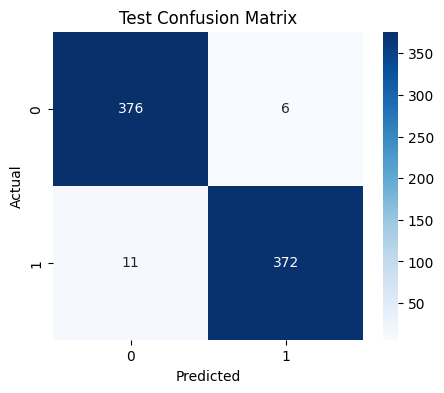

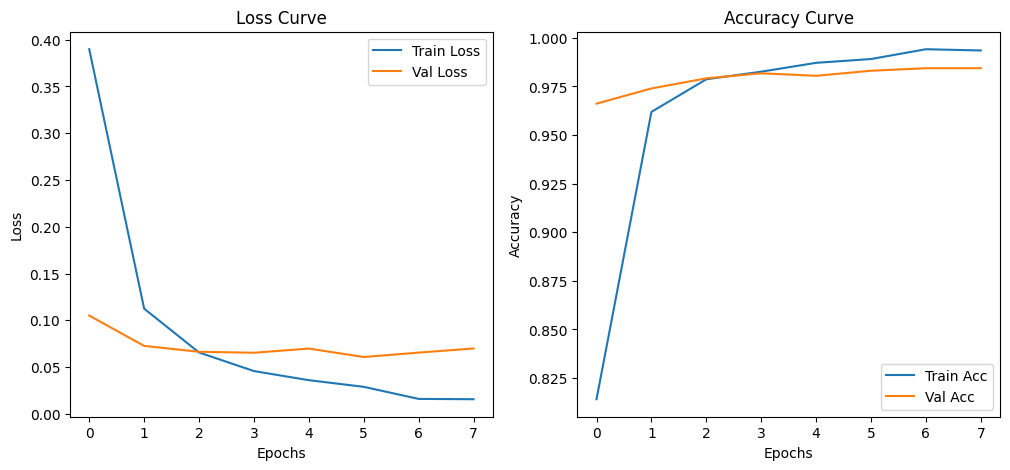

In [20]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Scheduler
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_val_loss = float('inf')
patience = 2
counter = 0

train_loss_set, val_loss_set = [], []
train_acc_set, val_acc_set = [], []

for epoch in range(EPOCHS):
    # Training
    model.train()
    total_loss, total_acc = 0, 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(DEVICE) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_acc += flat_accuracy(logits.detach().cpu().numpy(), b_labels.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = total_acc / len(train_dataloader)
    train_loss_set.append(avg_train_loss)
    train_acc_set.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0

    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(DEVICE) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        val_loss += loss.item()
        val_acc += flat_accuracy(logits.detach().cpu().numpy(), b_labels.detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_acc = val_acc / len(val_dataloader)
    val_loss_set.append(avg_val_loss)
    val_acc_set.append(avg_val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Test evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_acc, test_preds, test_labels_list = 0, [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(DEVICE) for t in batch)
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
    test_preds.extend(preds)
    test_labels_list.extend(b_labels.detach().cpu().numpy())

test_acc = accuracy_score(test_labels_list, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Test Confusion Matrix
cm = confusion_matrix(test_labels_list, test_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_set, label='Train Loss')
plt.plot(val_loss_set, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc_set, label='Train Acc')
plt.plot(val_acc_set, label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()
